# Distributed Compressed Sensing (Multi-Machine Version)

This notebook implements a **multi-machine distributed compressed sensing** experiment on heterogeneous devices, including **Raspberry Pi nodes** and commodity machines.  
Its purpose is to evaluate the **wall-clock runtime impact of communication quantization** in a resource-constrained distributed environment.

> **Note:** Before running this notebook, a Ray cluster must be manually set up by the user.

---

## Problem Formulation

We consider the centralized objective

$$
\min_{x \in \mathbb{R}^d}
\frac{1}{16}\sum_{i=1}^{16}\left(C_i \Psi x - y_i\right)^2
+ \lambda \|x\|_1 .
$$

Here, $C_i$ is the local measurement operator of worker $i$ (randomly selected rows of the identity matrix),  
$\Psi$ is the DCT basis, and $y_i$ is the corresponding local observation vector.  
The centralized optimal solution is denoted by $x^*$.

---

## Difference from the Single-Machine Multi-Process Notebook

The single-machine multi-process notebook mainly studies algorithm behavior and convergence.
In contrast, this notebook targets a **real multi-device setting** and focuses on **system-level wall-clock performance**, while omitting visualization and detailed convergence analysis.

---

## Main Objective

We compare the runtime of distributed optimization under

- **unquantized communication** (`float64`), and  
- **quantized communication** (`float64 → int16`).

The measured runtime corresponds to the **full execution of the algorithm**, and therefore includes both communication and **quantization/dequantization overhead**.

---

## Experimental Setup

A synchronous RAugDGM algorithm is executed on **16 workers**:

- 8 Raspberry Pi nodes (1 process each),
- 1 desktop machine (4 processes),
- 1 laptop (4 processes).

Since the system is synchronous, each iteration waits for all workers and the runtime is dominated by the slowest nodes, which are typically the Raspberry Pi devices.

---

## Experimental Design

- Each setting runs for **500 iterations**.
- In each round, we run:
  - 500 iterations with unquantized communication, and
  - 500 iterations with quantized communication.
- The **total wall-clock time per round** is measured on the coordinator.
- The experiment is repeated for **20 rounds**.
- Per-round runtimes are plotted to compare quantized and unquantized communication.

This notebook focuses solely on **runtime comparison between communication schemes**, rather than convergence or reconstruction accuracy.

In [1]:
import numpy as np
import numpy.typing as npt

from scipy.fftpack import dct

# Sensors
import networkx as nx

n_grid = 4
grid = nx.grid_2d_graph(n_grid, n_grid)
L: npt.NDArray[np.float64] = np.asarray(nx.laplacian_matrix(grid).todense())
W = np.eye(16) - L * 0.1

from topolink import Graph, bootstrap

graph = Graph.from_mixing_matrix(W, transport="tcp")
n_sens = graph.number_of_nodes
sens_names = [f"{i + 1}" for i in range(n_sens)]

# Original signal
n = 4096
t = np.linspace(0, 1, n)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)

# Signal sampling
np.random.seed(3)
p_total = 128
p_sens = p_total // n_sens
perm = {i: np.round(np.random.rand(p_sens) * n).astype(int) for i in sens_names}
y = {i: x[perm[i]] for i in sens_names}

# Sensing matrix and regularization parameter
Psi = dct(np.eye(n), norm="ortho").astype(np.float64, copy=False)
Theta = {i: Psi[perm[i], :] for i in sens_names}
lam = 0.01

# Time record
time_record: dict[str, list[float]] = {"quantized": [], "unquantized": []}

## Timing Evaluation of RAugDGM

This notebook focuses on evaluating the **runtime performance** of the distributed algorithm **RAugDGM** for a distributed LASSO problem arising from compressed sensing, rather than benchmarking multiple optimization algorithms.

The experiment is conducted on a $4 \times 4$ grid network.  
The gossip matrix is defined as

$$
W = I - 0.1 L,
$$

where $L$ is the Laplacian matrix of the communication graph.

We compare the execution time of RAugDGM using unquantized communication (float64) and quantized communication (float64 $\rightarrow$ int16).

In [ ]:
import ray

ray.init(address="auto")


@ray.remote(num_cpus=1)
def lasso(
    node_id: str,
    g_name: str,
    theta_i: npt.NDArray[np.float64],
    y_i: npt.NDArray[np.float64],
    dim_i: int,
    lam_i: float,
    max_iter: int,
    quantize: bool,
) -> float:
    from numpy import zeros

    s_hat_i = zeros((max_iter, dim_i), dtype=np.float64)

    # Define the loss function
    from jax import Array
    from jax.numpy.linalg import norm

    def f(var: npt.NDArray[np.float64]) -> Array:
        return norm(theta_i @ var - y_i) ** 2

    # Define the regularizer
    from dco import L1

    g = L1(lam_i)

    # Define the node handle
    from topolink import NodeHandle
    from topolink.transform import Quantize

    transform = Quantize(dtype="int16") if quantize else None

    nh = NodeHandle(node_id, g_name, transform=transform, transport="tcp")

    # Define the optimizer and run iterations
    from dco import RAugDGM

    optimizer = RAugDGM(f, nh, 1.358, g)

    import time

    begin_time = time.time()

    optimizer.init(s_hat_i[0])

    for k in range(max_iter - 1):
        s_hat_i[k + 1] = optimizer.step(s_hat_i[k])

    end_time = time.time()

    return end_time - begin_time


NUM_RUNS = 50
MAX_ITER = 100

try:
    for run in range(NUM_RUNS):
        graph.name = f"unquantized_{run}"

        bootstrap(graph)

        refs = [
            lasso.remote(i, graph.name, Theta[i], y[i], n, lam, MAX_ITER, False)
            for i in sens_names
        ]
        worker_times = ray.get(refs)
        max_time = max(worker_times)
        time_record["unquantized"].append(max_time)

        print(f"Unquantized run time: {max_time:.4f} seconds at run {run}")

    for run in range(NUM_RUNS):
        graph.name = f"quantized_{run}"

        bootstrap(graph)

        refs = [
            lasso.remote(i, graph.name, Theta[i], y[i], n, lam, MAX_ITER, True)
            for i in sens_names
        ]
        worker_times = ray.get(refs)
        max_time = max(worker_times)
        time_record["quantized"].append(max_time)

        print(f"Quantized run time: {max_time:.4f} seconds at run {run}")

finally:
    ray.shutdown()

2026-02-06 16:05:21,428	INFO worker.py:1821 -- Connecting to existing Ray cluster at address: 192.168.1.112:6379...
2026-02-06 16:05:21,436	INFO worker.py:1998 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


Unquantized run time: 21.4666 seconds at run 0
Unquantized run time: 21.9308 seconds at run 1
Unquantized run time: 20.0542 seconds at run 2
Unquantized run time: 19.4442 seconds at run 3
Unquantized run time: 22.4411 seconds at run 4
Unquantized run time: 18.8884 seconds at run 5
Unquantized run time: 18.3347 seconds at run 6
Unquantized run time: 17.4186 seconds at run 7
Unquantized run time: 22.6287 seconds at run 8
Unquantized run time: 18.5622 seconds at run 9
Unquantized run time: 18.9147 seconds at run 10
Unquantized run time: 20.7964 seconds at run 11
Unquantized run time: 18.7010 seconds at run 12
Unquantized run time: 19.2131 seconds at run 13
Unquantized run time: 22.1213 seconds at run 14
Unquantized run time: 20.2627 seconds at run 15
Unquantized run time: 17.7786 seconds at run 16
Unquantized run time: 17.4714 seconds at run 17
Unquantized run time: 20.1343 seconds at run 18
Unquantized run time: 21.3545 seconds at run 19
Unquantized run time: 18.9244 seconds at run 20
Un

## Plot results

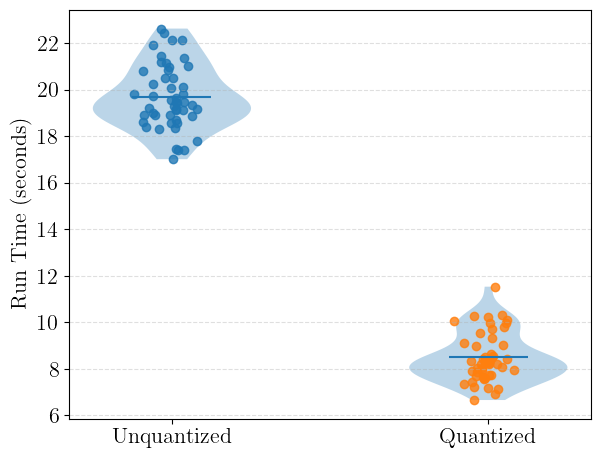

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True  # 使用外部 LaTeX 编译器
plt.rcParams["font.family"] = "serif"  # 设置字体为 LaTeX 的默认 serif 字体

plt.rcParams.update(
    {
        "font.size": 14,  # 全局字体大小
        "axes.titlesize": 16,  # 坐标轴标题字体大小
        "axes.labelsize": 16,  # 坐标轴标签字体大小
        "xtick.labelsize": 16,  # x轴刻度标签字体大小
        "ytick.labelsize": 16,  # y轴刻度标签字体大小
        "legend.fontsize": 13,  # 图例字体大小
    }
)

u = time_record["unquantized"]
q = time_record["quantized"]

fig, ax = plt.subplots()

ax.violinplot([u, q], showmeans=True, showextrema=False)

x1 = np.random.normal(1, 0.04, size=len(u))
x2 = np.random.normal(2, 0.04, size=len(q))

ax.scatter(x1, u, alpha=0.8)
ax.scatter(x2, q, alpha=0.8)
ax.grid(axis="y", linestyle="--", alpha=0.4)

ax.set_xticks([1, 2])
ax.set_xticklabels(["Unquantized", "Quantized"])
ax.set_ylabel("Run Time (seconds)")

fig.tight_layout()